# Getting Started
## How to fit RL Models
---

How to fit & diagnose Rescorla Wagner models.

**Relevant Resources**

- [multinomial logit](https://en.wikipedia.org/wiki/Multinomial_logistic_regression)
- [logit](https://en.wikipedia.org/wiki/Logistic_regression)
- [Rescorla Wagner model](https://en.wikipedia.org/wiki/Rescorla%E2%80%93Wagner_model)
- [Q-learning](https://en.wikipedia.org/wiki/Q-learning)
- [Sutton & Barto](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)
- [RL Tutorial: Q-learning](https://shawnrhoads.github.io/gu-psyc-347/module-03-01_Models-of-Learning.html)
- [RL Tutorial: Q-learning II](https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/)

---
```
: 20.06.2024
: zachcolinwolpe@gmail.com
```
---

In [1]:
import plotly.graph_objects as go
from scipy.optimize import minimize # finding optimal params in models
from scipy import stats             # statistical tools
import numpy as np                  # matrix/array functions
import pandas as pd                 # loading and manipulating data
import ipywidgets as widgets        # interactive display
import matplotlib.pyplot as plt     # plotting
%matplotlib inline

np.random.seed(2021)                # set seed for reproducibility

In [2]:
from src.rescorla_wagner_model import (RoscorlaWagner)
from src.rescorla_wagner_model_plots import (RescorlaWagnerPlots)
from src.rescorla_wagner_model_simulation import (RescorlaWagnerSimulate)
from src.rescorla_wagner_model_diagnostics import (RoscorlaWagerModelDiagnostics)

---
# Model 1: Rescorla-Wagner (RW) Model
---

How to fit a Rescorla-Wagner models.

[Source](https://shawnrhoads.github.io/gu-psyc-347/module-03-01_Models-of-Learning.html)

---
# Simulate Data
----

In [28]:
T = 250
K = 2
mu = [0.1, 0.9] # reward probabilities

# True (unknown) parameters
alpha = .3
theta = 2.5
params = [alpha, theta]


# simulate 
srw = RescorlaWagnerSimulate()
c3, r3, Q = srw.simulate(params, T=T, mu=mu, noisy_choice=True)

Plot simulated data

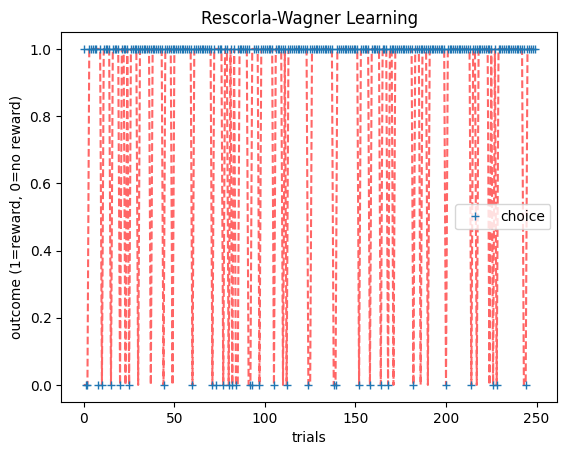

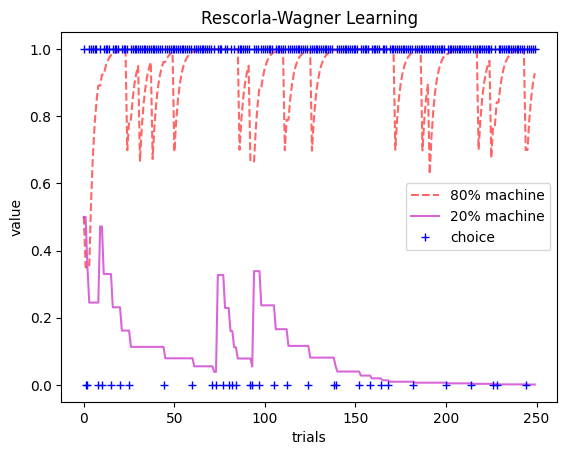

In [29]:
_plt = srw.plot_reward()
_plt.show()

_plt = srw.plot_Q_estimates()
_plt.show()

----
# Fit Sumlated Model
---

Fit parameter $\alpha$ assuming $\theta=1.5$

### Single Loglikelihood Evaluation

In [30]:
# Example evaluation:
# evaluate negative log-likelihood for 
# this simulated dataset at some other parameter values
alpha_hat = 0.2
theta_hat = 1.5
negLL = RoscorlaWagner.negll_RescorlaWagner([alpha_hat, theta_hat], srw.c, srw.r)

def log_parameters(alpha, theta, negLL):
    msg = f"""
        ----------------------------------------
        Model Fit:
            alpha: {alpha}
            theta: {theta}
            negLL: {negLL}
        ----------------------------------------
        """
    print(msg)

log_parameters(alpha_hat, theta_hat, negLL)


        ----------------------------------------
        Model Fit:
            alpha: 0.2
            theta: 1.5
            negLL: 103.89883152728476
        ----------------------------------------
        


---
# Fit Model: Brute Force Search
----

Brute force search $\alpha$ (assuming $\theta$ is known for simplicity).

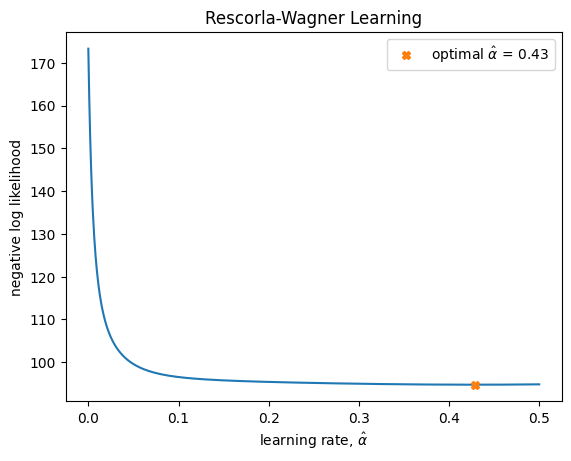

In [32]:
nLL = []
alpha_vals = np.linspace(0,0.5,1000)
for alpha_val in alpha_vals:
    nLL.append(RoscorlaWagner.negll_RescorlaWagner([alpha_val, theta], srw.c, srw.r))

plt.plot(alpha_vals, nLL, '-')
plt.plot(alpha_vals[np.argmin(nLL)], nLL[np.argmin(nLL)], 'X', label=r'optimal $\hat \alpha$ = %.2f' % alpha_vals[np.argmin(nLL)])
plt.ylabel('negative log likelihood')
plt.xlabel(fr'learning rate, $\hat \alpha$')
plt.title(f'Rescorla-Wagner Learning')
plt.legend()
plt.show()


---
# Fit Model: Maximum likelihood estimation (MLE)
### `argmin: NegLogLikelihood`
----

Fit the parameters using MLE. Repeat this N times, varying the starting point estimates to account for local maximum.

In [33]:
param_fits, BIC = RoscorlaWagner.fit_rescorla_wagner_model_n_times(
    action_vector=srw.c,
    reward_vector=srw.r,
    alpha_range=np.linspace(0,1,10),
    theta_range=np.linspace(1,25,10),
    alpha_bound=(0,1),
    theta_bound=(1,50))
       

 20%|██        | 2/10 [00:01<00:06,  1.25it/s]/Users/zachwolpe/Desktop/µπ/perceptual_attention_learning/reinforcement_learning/src/rescorla_wagner_model.py:96: RuntimeWarning:

divide by zero encountered in log

 30%|███       | 3/10 [00:02<00:05,  1.39it/s]/Users/zachwolpe/miniforge3/envs/mlxgo/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning:

invalid value encountered in subtract

100%|██████████| 10/10 [00:06<00:00,  1.48it/s]

Neg Log Likelihood fit complete.
alpha_hat = 0.46, theta_hat = 2.28
BIC = 199.73


## Examine fit parameters

In [35]:
msg = """
    Fit Parameters:
    ---------------
        : alpha: %.2f
        : theta: %.2f
    """ % (param_fits[0], param_fits[1])
print(msg)
param_fits


    Fit Parameters:
    ---------------
        : alpha: 0.46
        : theta: 2.28
    


array([0.46424591, 2.28108756])

---
# Infer Q-values & Choice Probabilities
----

Given the assumed model parameters, we can now infer the Q-values and choice probabilities. This can be used for model diagnostics, accuracy assessment, and model comparison.

In [36]:
Q_stored, predicted_action_vector, action_probabilities = \
   RoscorlaWagerModelDiagnostics.generate_Q_values(
      param_fits,
      action_vector=srw.c,
      reward_vector=srw.r)
   

For a safety check, compare the inferred Q-values to the true Q-values (we only have access to the true Q-values in this simulated example).

To implement a assertion, use:

```python
for _q1, _q2 in zip(Q_stored, srw.Q_stored):
    for q1, q2 in zip(_q1, _q2):
        np.testing.assert_almost_equal(q1, q2, decimal=2)
```

This approach is not used as our simulation included random pertubations. We instead examine the Q-values visually.

In [37]:
Q_stored, srw.Q_stored
X = pd.DataFrame(Q_stored).T
X.columns = ['Q=0 (infered)', 'Q=1 (infered)']
X['Q=0 (true)'] = srw.Q_stored[0]
X['Q=1 (true)'] = srw.Q_stored[1]
X = X[['Q=0 (true)', 'Q=0 (infered)', 'Q=1 (true)', 'Q=1 (infered)']]
X

,Q=0 (true),Q=0 (infered),Q=1 (true),Q=1 (infered)
0,0.500000,0.372362,0.500000,0.706211
1,0.500000,0.372362,0.350000,0.378356
2,0.350000,0.199494,0.350000,0.378356
3,0.245000,0.106880,0.350000,0.378356
4,0.245000,0.106880,0.545000,0.666951
...,...,...,...,...
245,0.001125,0.000022,0.699245,0.535742
246,0.001125,0.000022,0.789471,0.751272
247,0.001125,0.000022,0.852630,0.866743
248,0.001125,0.000022,0.896841,0.928607


<module 'matplotlib.pyplot' from '/Users/zachwolpe/miniforge3/envs/mlxgo/lib/python3.12/site-packages/matplotlib/pyplot.py'>

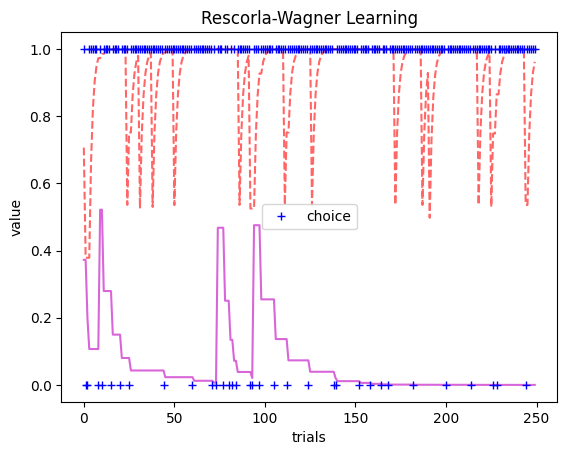

In [38]:
# Infered
RescorlaWagnerPlots.plot_Q_estimates(Q_values=Q_stored, choice_vector=srw.c)

<module 'matplotlib.pyplot' from '/Users/zachwolpe/miniforge3/envs/mlxgo/lib/python3.12/site-packages/matplotlib/pyplot.py'>

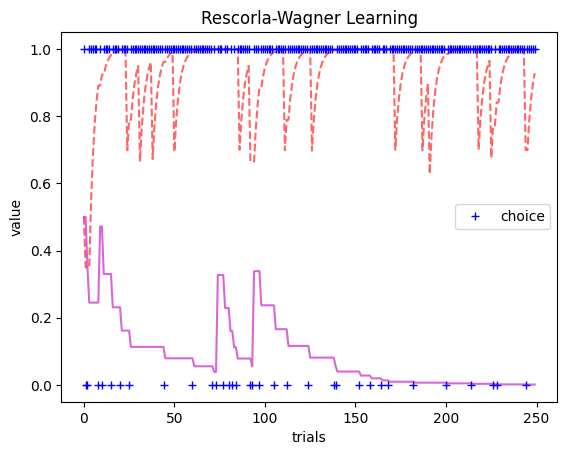

In [39]:
RescorlaWagnerPlots.plot_Q_estimates(Q_values=srw.Q_stored, choice_vector=srw.c)


---
# Extract  Parameters
---

Extract the fitted parameters & action/reward sequences for diagnostics.

In [40]:
ACTION_VECTOR = srw.c
REWARD_VECTOR = srw.r
PARAMS = param_fits
Q_VALUES = Q_stored

In [41]:

x_vector, prob_of_success = RoscorlaWagerModelDiagnostics.calc_prob_of_success(REWARD_VECTOR, bin_size=5)



frac = 0.4
x_loess, y_loess = RoscorlaWagerModelDiagnostics.fit_loess(x_vector, prob_of_success, frac=frac)
fig = RescorlaWagnerPlots.plot_metric(x_vector, prob_of_success)
fig.add_trace(go.Scatter(x=x_loess, y=y_loess, mode='lines', line_color='red', name=f'loess frac:{frac}'))


In [42]:
metrics = RoscorlaWagerModelDiagnostics.calc_confusion_matrix(ACTION_VECTOR, REWARD_VECTOR, bin_size=5)
metrics['group_midpoint'] = metrics.apply(lambda x: (x['start_index'] + x['end_index'])/2, axis=1)
metrics.head(3)

,start_index,end_index,TP,FP,TN,FN,senstivity,specificity,precision,recall,accuracy,F_score,group_midpoint
0,0,5,2,1,2,0,1.0,0.666667,0.666667,1.0,0.8,0.800000,2.5
1,5,10,4,0,0,1,0.8,NaN,1.000000,0.8,0.8,0.888889,7.5
2,10,15,4,0,1,0,1.0,1.000000,1.000000,1.0,1.0,1.000000,12.5


In [43]:
X_vector = metrics['group_midpoint']
y = metrics['senstivity']

fig = go.Figure()
for _y in ['senstivity', 'specificity', 'precision', 'recall', 'accuracy', 'F_score']:
    fig = RescorlaWagnerPlots.plot_metric(x_vector, metrics[_y], name=_y, fig=fig, color=None, dash='solid')

fig.update_layout(template='none', title='Model Diagnostics', xaxis_title='Trial', yaxis_title='Metric Value per bin')
fig.show()


---
# Grid Search & Grid Evaluation
----

We can implement a grid search to test the cost function (negative log likelihood) for a matrix of input values. This is less efficient than searching for the minimum directly, but can be useful for visualizing the cost function.

In [44]:

nLL, grid_df_to_plot = RoscorlaWagner.grid_search(ACTION_VECTOR, REWARD_VECTOR, alpha_range=np.linspace(0,1,100), theta_range=np.linspace(1,25,100))

100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


In [45]:
RescorlaWagnerPlots.plot_grid_opt(grid_df_to_plot)


----
# Experiment: Parameter Estimate Stability
---

To test the robustness of this approach, we can simulate N experiments with different starting values & examine the model's ability to retrieve these parameters.

In [62]:
alpha_true_range = np.linspace(0,1,10)
theta_true_range = np.linspace(1,10,10)


results = {'alpha (true)':[], 'alpha (pred)':[], 'theta (true)':[], 'theta (pred)':[]}


for alpha in alpha_true_range:
    for theta in theta_true_range:
        params = (alpha, theta)

# for params in zip(alpha_true_range, theta_true_range):

        # generate data
        srw = RescorlaWagnerSimulate()
        srw.simulate(params, T=100, mu=[0.2, 0.8], noisy_choice=True)


        # fit parametes
        param_fits, BIC = RoscorlaWagner.fit_rescorla_wagner_model_n_times(
            action_vector=srw.c,
            reward_vector=srw.r,
            alpha_range=np.linspace(0,1,10),
            theta_range=np.linspace(1,15,10),
            alpha_bound=(0,1),
            theta_bound=(1,25))

        # store results
        results['alpha (true)'].append(params[0])
        results['alpha (pred)'].append(param_fits[0])
        results['theta (true)'].append(params[1])
        results['theta (pred)'].append(param_fits[1])
       
    

100%|██████████| 10/10 [00:00<00:00, 54.50it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.00, theta_hat = 1.00
BIC = 147.84


100%|██████████| 10/10 [00:14<00:00,  1.44s/it]


Neg Log Likelihood fit complete.
alpha_hat = 0.00, theta_hat = 25.00
BIC = 142.35


100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


Neg Log Likelihood fit complete.
alpha_hat = 0.00, theta_hat = 25.00
BIC = 145.91


100%|██████████| 10/10 [00:01<00:00,  6.01it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.01, theta_hat = 1.00
BIC = 147.72


100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.00, theta_hat = 25.00
BIC = 147.83


100%|██████████| 10/10 [00:03<00:00,  2.70it/s]


Neg Log Likelihood fit complete.
alpha_hat = 1.00, theta_hat = 1.00
BIC = 143.98


100%|██████████| 10/10 [00:00<00:00, 33.04it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.00, theta_hat = 1.00
BIC = 147.84


100%|██████████| 10/10 [00:01<00:00,  8.16it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.01, theta_hat = 1.00
BIC = 147.53


100%|██████████| 10/10 [00:01<00:00,  7.39it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.01, theta_hat = 1.00
BIC = 147.67


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.00, theta_hat = 25.00
BIC = 147.69


100%|██████████| 10/10 [00:01<00:00,  6.77it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.17, theta_hat = 1.00
BIC = 142.53


100%|██████████| 10/10 [00:01<00:00,  6.05it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.24, theta_hat = 1.33
BIC = 135.08


100%|██████████| 10/10 [00:01<00:00,  5.45it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.35, theta_hat = 2.91
BIC = 89.21


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.08, theta_hat = 4.82
BIC = 92.13


100%|██████████| 10/10 [00:02<00:00,  4.62it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.11, theta_hat = 5.67
BIC = 75.59


100%|██████████| 10/10 [00:02<00:00,  4.04it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.16, theta_hat = 5.88
BIC = 82.62


100%|██████████| 10/10 [00:04<00:00,  2.20it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.10, theta_hat = 6.19
BIC = 63.10


100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.03, theta_hat = 25.00
BIC = 54.61


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.35, theta_hat = 9.37
BIC = 23.79


100%|██████████| 10/10 [00:02<00:00,  3.77it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.06, theta_hat = 11.58
BIC = 78.46


100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.00, theta_hat = 25.00
BIC = 140.75


100%|██████████| 10/10 [00:02<00:00,  4.29it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.32, theta_hat = 2.19
BIC = 112.50


100%|██████████| 10/10 [00:02<00:00,  4.21it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.22, theta_hat = 3.20
BIC = 87.89


100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.09, theta_hat = 5.32
BIC = 97.65


100%|██████████| 10/10 [00:03<00:00,  2.72it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.27, theta_hat = 5.59
BIC = 38.35


100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.43, theta_hat = 7.01
BIC = 46.49


100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.33, theta_hat = 9.88
BIC = 23.01


100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.04, theta_hat = 25.00
BIC = 20.91


100%|██████████| 10/10 [00:02<00:00,  4.28it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.43, theta_hat = 7.34
BIC = 28.30


100%|██████████| 10/10 [00:02<00:00,  4.06it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.40, theta_hat = 9.09
BIC = 34.97


100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.08, theta_hat = 2.02
BIC = 136.55


100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.53, theta_hat = 1.90
BIC = 116.01


100%|██████████| 10/10 [00:02<00:00,  4.95it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.29, theta_hat = 2.83
BIC = 121.45


100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.25, theta_hat = 4.91
BIC = 64.88


100%|██████████| 10/10 [00:02<00:00,  3.78it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.40, theta_hat = 5.38
BIC = 51.12


100%|██████████| 10/10 [00:02<00:00,  3.89it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.29, theta_hat = 9.16
BIC = 42.58


100%|██████████| 10/10 [00:02<00:00,  3.89it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.29, theta_hat = 5.61
BIC = 49.53


100%|██████████| 10/10 [00:02<00:00,  4.44it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.29, theta_hat = 7.34
BIC = 66.82


100%|██████████| 10/10 [00:02<00:00,  4.35it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.37, theta_hat = 9.66
BIC = 25.15


100%|██████████| 10/10 [00:02<00:00,  4.19it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.38, theta_hat = 7.66
BIC = 43.45


100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.09, theta_hat = 2.10
BIC = 124.44


100%|██████████| 10/10 [00:01<00:00,  5.16it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.46, theta_hat = 1.54
BIC = 124.73


100%|██████████| 10/10 [00:01<00:00,  5.06it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.48, theta_hat = 2.49
BIC = 103.61


100%|██████████| 10/10 [00:02<00:00,  4.99it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.37, theta_hat = 3.59
BIC = 81.99


100%|██████████| 10/10 [00:02<00:00,  4.45it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.31, theta_hat = 4.30
BIC = 70.61


100%|██████████| 10/10 [00:02<00:00,  4.36it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.54, theta_hat = 5.76
BIC = 45.69


100%|██████████| 10/10 [00:02<00:00,  3.90it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.48, theta_hat = 7.22
BIC = 37.95


100%|██████████| 10/10 [00:02<00:00,  4.22it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.39, theta_hat = 8.16
BIC = 27.95


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.20, theta_hat = 8.50
BIC = 34.07


100%|██████████| 10/10 [00:02<00:00,  3.58it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.30, theta_hat = 14.79
BIC = 20.29


100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.70, theta_hat = 1.06
BIC = 131.13


100%|██████████| 10/10 [00:01<00:00,  5.14it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.87, theta_hat = 2.30
BIC = 97.70


100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.53, theta_hat = 3.95
BIC = 69.33


100%|██████████| 10/10 [00:01<00:00,  5.15it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.68, theta_hat = 3.47
BIC = 76.76


100%|██████████| 10/10 [00:02<00:00,  4.83it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.51, theta_hat = 4.59
BIC = 66.19


100%|██████████| 10/10 [00:02<00:00,  4.82it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.64, theta_hat = 4.57
BIC = 61.76


100%|██████████| 10/10 [00:02<00:00,  3.86it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.42, theta_hat = 6.94
BIC = 35.93


100%|██████████| 10/10 [00:02<00:00,  4.02it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.50, theta_hat = 8.53
BIC = 34.66


100%|██████████| 10/10 [00:02<00:00,  4.30it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.58, theta_hat = 10.83
BIC = 26.12


100%|██████████| 10/10 [00:02<00:00,  3.87it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.65, theta_hat = 11.19
BIC = 37.89


100%|██████████| 10/10 [00:01<00:00,  9.04it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.93, theta_hat = 1.00
BIC = 137.49


100%|██████████| 10/10 [00:02<00:00,  4.41it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.72, theta_hat = 2.22
BIC = 97.48


100%|██████████| 10/10 [00:01<00:00,  5.12it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.85, theta_hat = 3.27
BIC = 77.59


100%|██████████| 10/10 [00:03<00:00,  3.29it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.45, theta_hat = 4.06
BIC = 56.18


100%|██████████| 10/10 [00:02<00:00,  3.88it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.76, theta_hat = 13.35
BIC = 29.32


100%|██████████| 10/10 [00:02<00:00,  4.80it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.56, theta_hat = 5.33
BIC = 60.18


100%|██████████| 10/10 [00:02<00:00,  3.43it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.72, theta_hat = 9.73
BIC = 23.13


100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.82, theta_hat = 25.00
BIC = 18.18


100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.53, theta_hat = 7.87
BIC = 31.79


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.94, theta_hat = 25.00
BIC = 38.52


100%|██████████| 10/10 [00:01<00:00,  5.04it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.74, theta_hat = 1.03
BIC = 136.15


100%|██████████| 10/10 [00:02<00:00,  4.62it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.82, theta_hat = 2.18
BIC = 102.44


100%|██████████| 10/10 [00:02<00:00,  4.67it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.77, theta_hat = 2.98
BIC = 88.84


100%|██████████| 10/10 [00:02<00:00,  3.93it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.47, theta_hat = 5.18
BIC = 51.34


100%|██████████| 10/10 [00:02<00:00,  4.65it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.88, theta_hat = 4.66
BIC = 59.21


100%|██████████| 10/10 [00:02<00:00,  4.22it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.61, theta_hat = 5.57
BIC = 59.31


100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.84, theta_hat = 9.76
BIC = 39.12


100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.88, theta_hat = 11.41
BIC = 31.71


100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.80, theta_hat = 8.49
BIC = 50.16


100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.85, theta_hat = 25.00
BIC = 24.21


100%|██████████| 10/10 [00:02<00:00,  3.71it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.92, theta_hat = 1.00
BIC = 139.45


100%|██████████| 10/10 [00:01<00:00,  6.01it/s]


Neg Log Likelihood fit complete.
alpha_hat = 1.00, theta_hat = 1.64
BIC = 111.23


100%|██████████| 10/10 [00:02<00:00,  4.72it/s]


Neg Log Likelihood fit complete.
alpha_hat = 1.00, theta_hat = 2.56
BIC = 88.40


100%|██████████| 10/10 [00:02<00:00,  3.99it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.80, theta_hat = 6.19
BIC = 50.44


100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.97, theta_hat = 14.48
BIC = 48.91


100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.94, theta_hat = 25.00
BIC = 34.64


100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.89, theta_hat = 4.44
BIC = 63.01


100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.97, theta_hat = 23.50
BIC = 49.11


100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.92, theta_hat = 25.00
BIC = 40.89


100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.97, theta_hat = 25.00
BIC = 60.76


100%|██████████| 10/10 [00:01<00:00,  5.41it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.17, theta_hat = 1.46
BIC = 139.34


100%|██████████| 10/10 [00:02<00:00,  4.76it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.63, theta_hat = 2.05
BIC = 101.78


100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


Neg Log Likelihood fit complete.
alpha_hat = 1.00, theta_hat = 3.74
BIC = 77.84


100%|██████████| 10/10 [00:02<00:00,  4.32it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.99, theta_hat = 4.33
BIC = 70.20


100%|██████████| 10/10 [00:02<00:00,  4.51it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.83, theta_hat = 4.19
BIC = 69.22


100%|██████████| 10/10 [00:02<00:00,  3.38it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.96, theta_hat = 12.34
BIC = 59.59


100%|██████████| 10/10 [00:03<00:00,  2.88it/s]


Neg Log Likelihood fit complete.
alpha_hat = 1.00, theta_hat = 25.00
BIC = 54.92


100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Neg Log Likelihood fit complete.
alpha_hat = 1.00, theta_hat = 23.81
BIC = 61.89


100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


Neg Log Likelihood fit complete.
alpha_hat = 0.95, theta_hat = 13.70
BIC = 48.31


100%|██████████| 10/10 [00:03<00:00,  2.74it/s]

Neg Log Likelihood fit complete.
alpha_hat = 0.99, theta_hat = 25.00
BIC = 47.50


In [65]:
_results = pd.DataFrame(results)
print(_results.shape)
_results.head()

(100, 4)


,alpha (true),alpha (pred),theta (true),theta (pred)
0,0.0,0.000000,1.0,1.0
1,0.0,0.000969,2.0,25.0
2,0.0,0.000649,3.0,25.0
3,0.0,0.006654,4.0,1.0
4,0.0,0.000052,5.0,25.0


In [87]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=_results['alpha (true)'], y=_results['alpha (pred)'], mode='markers', name='alpha'),
    row=1, col=1
)

# add linear line
_x = np.linspace(0,1,100)
_y = _x
fig.add_trace(go.Scatter(x=_x, y=_y, mode='lines', marker_color='black', name='y=x', showlegend=False),row=1, col=1)

fig.add_trace(
    go.Scatter(x=_results['theta (true)'], y=_results['theta (pred)'], mode='markers', name='theta'),
    row=1, col=2
)
# add linear line
_x = np.linspace(0,10,100)
_y = _x
fig.add_trace(go.Scatter(x=_x, y=_y, mode='lines', marker_color='black', name='y=x', showlegend=False),row=1, col=2)

fig.update_layout(height=600, width=800, title_text="Sensitivity Analysis: Parameter Stability Estimate", template='none')
fig.show()